# Unsupervised Learning Modeling

This notebook carries out basic unsupervised learning modeling of the [Dataset of songs in Spotify](https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify).

Note that the present notebook is not tracked with Weights and Biases. To see how to track notebooks, have a look at [`EDA_Tracked.ipynb`](EDA_Tracked.ipynb).

Table of contents:

1. [Basic EDA](#1.-Basic-EDA)
2. [Processing](#2.-Processing)
    - [Impute `loudness` with KNN](#Impute-`loudness`-with-KNN)
    - [Define Types of Columns](#Define-Types-of-Columns)
    - [Encode Numericals: Transform if Skewed](#Encode-Numericals:-Transform-if-Skewed)
    - [Encode Categoricals](#Encode-Categoricals)
    - [Encode Text Features](#Encode-Text-Features)
    - [Assemble All Columns and Scale](#Assemble-All-Columns-and-Scale)
    - [Encode Targets](#Encode-Targets)
3. [Clustering](#Clustering)


## 1. Basic EDA

In [1]:
import sys
import itertools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_parquet('../dataset/genres_mod.parquet')

In [4]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,genre,song_name,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,124539,4,Dark Trap,Mercury: Retrograde,None
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,224427,4,Dark Trap,Pathology,None
2,0.850,0.893,5,NaN,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,98821,4,Dark Trap,Symbiote,None
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),None
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,123298,4,Dark Trap,Venom,None


In [5]:
# Missing values in
# - loudness
# - song_name
# - title (album?)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42896 entries, 0 to 42895
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42896 non-null  float64
 1   energy            42896 non-null  float64
 2   key               42896 non-null  int64  
 3   loudness          33726 non-null  float64
 4   mode              42896 non-null  int64  
 5   speechiness       42896 non-null  float64
 6   acousticness      42896 non-null  float64
 7   instrumentalness  42896 non-null  float64
 8   liveness          42896 non-null  float64
 9   valence           42896 non-null  float64
 10  tempo             42896 non-null  float64
 11  type              42896 non-null  object 
 12  duration_ms       42896 non-null  int64  
 13  time_signature    42896 non-null  int64  
 14  genre             42896 non-null  object 
 15  song_name         21811 non-null  object 
 16  title             21079 non-null  object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,42896.0,0.639336,0.156585,0.065100,0.52400,0.64600,0.7660,0.988
energy,42896.0,0.762560,0.183691,0.000243,0.63200,0.80300,0.9230,1.000
key,42896.0,5.368566,3.664993,0.000000,1.00000,6.00000,9.0000,11.000
loudness,33726.0,-6.463899,2.938171,-32.929000,-8.16500,-6.22850,-4.5200,3.148
mode,42896.0,0.549492,0.497550,0.000000,0.00000,1.00000,1.0000,1.000
speechiness,42896.0,0.136446,0.125976,0.022700,0.04910,0.07540,0.1930,0.946
acousticness,42896.0,0.096260,0.170843,0.000001,0.00173,0.01640,0.1070,0.988
instrumentalness,42896.0,0.283229,0.370810,0.000000,0.00000,0.00596,0.7220,0.989
liveness,42896.0,0.214080,0.175463,0.010700,0.09960,0.13500,0.2940,0.988
valence,42896.0,0.357170,0.233255,0.018700,0.16100,0.32200,0.5220,0.988


<AxesSubplot:>

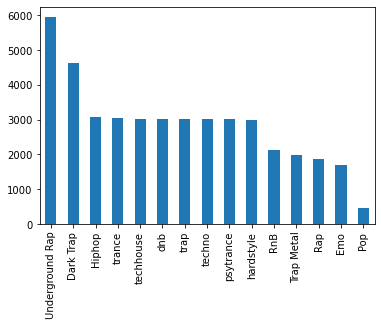

In [7]:
df['genre'].value_counts().plot(kind='bar')

In [8]:
df['song_name']

0                                  Mercury: Retrograde
1                                            Pathology
2                                             Symbiote
3        ProductOfDrugs (Prod. The Virus and Antidote)
4                                                Venom
                             ...                      
42891                                       Bang Bros!
42892                                             None
42893                                             None
42894                               Southern Hostility
42895                                             None
Name: song_name, Length: 42896, dtype: object

<AxesSubplot:ylabel='Frequency'>

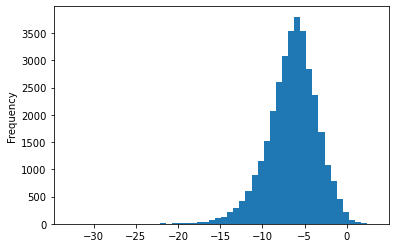

In [9]:
df['loudness'].plot(kind='hist', bins=50)

<AxesSubplot:>

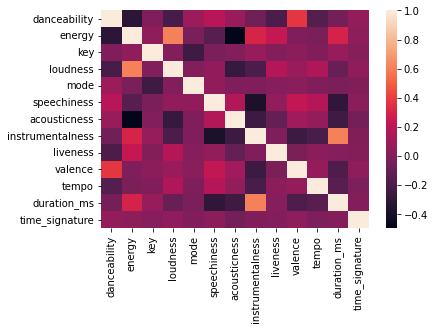

In [10]:
sns.heatmap(df.corr())

In [11]:
# Loudness seems to be quite correlated
# with some variables:
# energy, liveliness, acousticness, daceablity, instrumentalness
# It seems reasonable to use KNN to impute the missing values
df.corr()['loudness'].sort_values()

acousticness       -0.285024
danceability       -0.215901
instrumentalness   -0.193452
duration_ms        -0.096771
mode               -0.005488
key                -0.004448
time_signature      0.044419
speechiness         0.049049
valence             0.081257
tempo               0.152138
liveness            0.170606
energy              0.603524
loudness            1.000000
Name: loudness, dtype: float64

In [12]:
df['time_signature'].value_counts()

4    40999
3     1227
5      519
1      151
Name: time_signature, dtype: int64

In [13]:
df['key'].value_counts()

1     7641
7     4332
11    4197
6     3767
0     3520
8     3405
10    3294
9     3293
2     3093
5     3047
4     2397
3      910
Name: key, dtype: int64

In [14]:
df['mode'].value_counts()

1    23571
0    19325
Name: mode, dtype: int64

In [15]:
# Get all possible genres
# Genre is the target variable in the dataset
df['genre'].unique()

array(['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB',
       'Pop', 'Hiphop', 'techhouse', 'techno', 'trance', 'psytrance',
       'trap', 'dnb', 'hardstyle'], dtype=object)

In [16]:
# All type fields are 'audio_features'
df['type'].value_counts()

audio_features    42896
Name: type, dtype: int64

## 2. Processing

In [17]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
# A minimal feature engineering step: a new feature = song name + title
df['title'].fillna(value='', inplace=True)
df['song_name'].fillna(value='', inplace=True)
df['text_feature'] = df['title'] + ' ' + df['song_name']
X = df.drop(['title', 'song_name', 'type'], axis=1)

In [19]:
# We can see that after merging title and song_name
# the only feature with NAs remains to be loudness
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41975 entries, 0 to 41974
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      41975 non-null  float64
 1   energy            41975 non-null  float64
 2   key               41975 non-null  int64  
 3   loudness          32968 non-null  float64
 4   mode              41975 non-null  int64  
 5   speechiness       41975 non-null  float64
 6   acousticness      41975 non-null  float64
 7   instrumentalness  41975 non-null  float64
 8   liveness          41975 non-null  float64
 9   valence           41975 non-null  float64
 10  tempo             41975 non-null  float64
 11  duration_ms       41975 non-null  int64  
 12  time_signature    41975 non-null  int64  
 13  genre             41975 non-null  object 
 14  text_feature      41975 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 4.8+ MB


### Impute `loudness` with KNN

In [20]:
# Remove original target and text
X_tmp = X.drop(['text_feature', 'genre'], axis=1)

In [21]:
# Encode whether loudness is available or not
X_tmp['has_loudness'] = (X_tmp['loudness'].isna() == False)

In [22]:
# Get training samples
X_train = X_tmp[X_tmp.has_loudness==True].drop(['loudness'], axis=1)
y_train = X_tmp[X_tmp.has_loudness==True]['loudness']

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Intantiate a KNN Regressor
knnr = KNeighborsRegressor()

# Grid search
search = GridSearchCV(estimator=knnr,
                      param_grid=param_grid,
                      cv=5,
                      scoring='neg_mean_squared_error')

# Find best hyperparameters and best estimator pipeline
search.fit(X_train_scaled, y_train)
estimator = search.best_estimator_

In [25]:
search.best_score_

-4.779581678746105

In [26]:
search.best_params_

{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

In [27]:
# Predict training target
y_pred = estimator.predict(X_train_scaled)

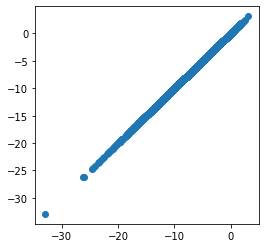

In [28]:
# Plot real vs predicted in training set
plt.figure(figsize=(4,4))
plt.scatter(y_train, y_pred)

In [29]:
# Predict the missing loudness values
X_missing = X_tmp[X_tmp.has_loudness==False].drop(['loudness'], axis=1)
X_missing_scaled = scaler.transform(X_missing)
y_missing = estimator.predict(X_missing_scaled)

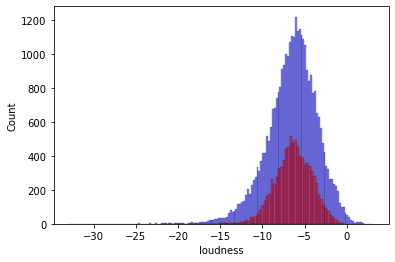

In [30]:
# Plot the distributions
# The seem to be quite 
sns.histplot(y_train, color='b', alpha=0.5)
sns.histplot(y_missing, color='r', alpha=0.5)
plt.show()

In [31]:
# Assemble the new dataset
X.loc[X_tmp.has_loudness==False, 'loudness'] = y_missing

In [32]:
# Now, there are no missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41975 entries, 0 to 41974
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      41975 non-null  float64
 1   energy            41975 non-null  float64
 2   key               41975 non-null  int64  
 3   loudness          41975 non-null  float64
 4   mode              41975 non-null  int64  
 5   speechiness       41975 non-null  float64
 6   acousticness      41975 non-null  float64
 7   instrumentalness  41975 non-null  float64
 8   liveness          41975 non-null  float64
 9   valence           41975 non-null  float64
 10  tempo             41975 non-null  float64
 11  duration_ms       41975 non-null  int64  
 12  time_signature    41975 non-null  int64  
 13  genre             41975 non-null  object 
 14  text_feature      41975 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 4.8+ MB


### Define Types of Columns

In [33]:
numeric_features = sorted([
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
])

categorical_features = sorted([
    "time_signature",
    "key"
])

binary_features = sorted([
    "mode"
])

nlp_feature = "text_feature"

target = "genre"

### Encode Numericals: Transform if Skewed

This transformation is not needed for all algorithms, but I do it just in case I try someting which requires it.

In [34]:
for col in numeric_features:
    if np.abs(X[col].skew()) > 0.75:
        X[col] = np.log1p(X[col])

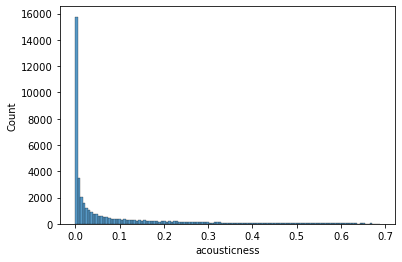

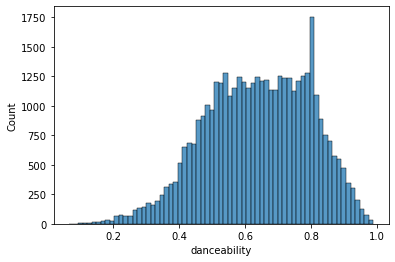

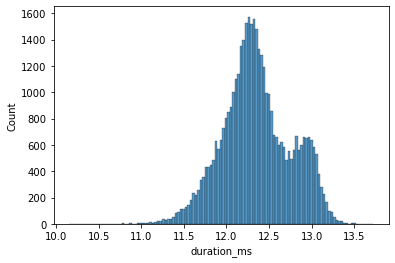

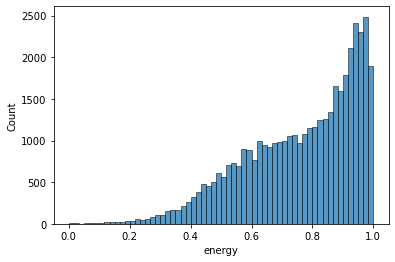

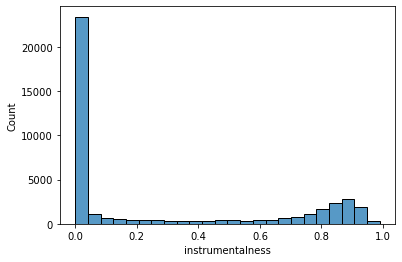

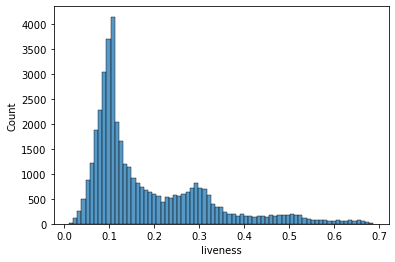

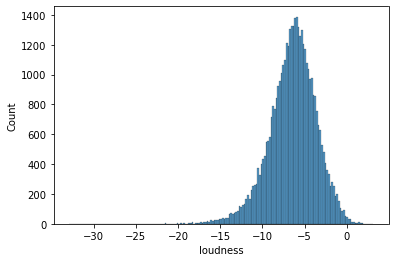

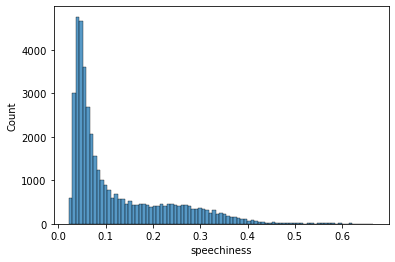

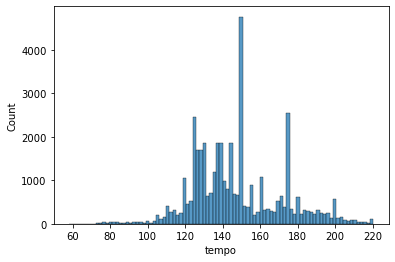

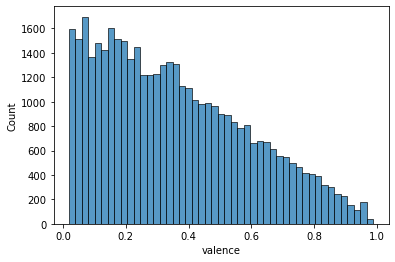

In [35]:
for col in numeric_features:
    sns.histplot(X[col])
    plt.show()

### Encode Categoricals

In [36]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoders = dict()
for col in categorical_features:
    oe = OrdinalEncoder()
    X[col] = oe.fit_transform(X[col].values.reshape(-1, 1))
    ordinal_encoders[col] = oe

### Encode Text Features

In [46]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [47]:
# Distirbution of text_feature word counts
lengths = [len(field[0].split(' ')) for field in X[[nlp_feature]].values]

<AxesSubplot:ylabel='Count'>

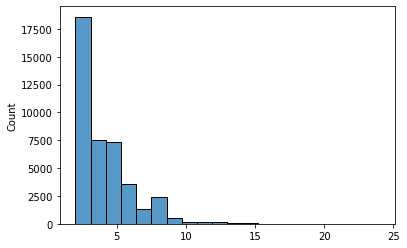

In [48]:
sns.histplot(lengths,bins=20)

In [49]:
# Custom text processing function
def preprocess_text(text):
    text = text.lower()
    # Remove all digits 
    text = re.sub(r'\d+', '', text)
    return text

In [50]:
# TF-IDF
tfidf = TfidfVectorizer(max_features = 500, preprocessor = preprocess_text)
tfidf_mat = tfidf.fit_transform(X[nlp_feature])
# Convert to a dataframe
# TfidfVectorizer normalizes each row to length 1
tfidf_df = pd.DataFrame(tfidf_mat.toarray(), columns = tfidf.get_feature_names_out())
# 1586 rows × 500 columns

In [51]:
tfidf_df

,about,acid,again,ain,album,alive,all,alone,am,and,...,ya,yachty,year,yg,yo,you,young,your,yourself,yung
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assemble All Columns and Scale

In [52]:
all_features = numeric_features + categorical_features + binary_features # + [nlp_feature]

In [53]:
y = X[target]

In [54]:
X = X[all_features]

In [55]:
X = pd.concat([X, tfidf_df], axis=1).reset_index()

In [56]:
X

,index,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,ya,yachty,year,yg,yo,you,young,your,yourself,yung
0,0,0.058080,0.831,11.732382,0.814,0.013400,0.054109,-7.364000,0.350657,156.985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.337186,0.719,12.321310,0.493,0.000000,0.111541,-7.230000,0.076405,115.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.013706,0.850,11.501076,0.893,0.000004,0.316270,-5.833318,0.060436,218.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.023424,0.476,11.725307,0.781,0.000000,0.107957,-4.710000,0.098034,186.948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.196389,0.798,11.722368,0.624,0.000000,0.153579,-7.668000,0.256965,147.988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41970,41970,0.031014,0.528,12.503243,0.693,0.000345,0.114221,-5.148000,0.029947,150.013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41971,41971,0.022251,0.517,12.255401,0.768,0.000018,0.186480,-7.922000,0.046788,149.928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41972,41972,0.025668,0.361,12.366592,0.821,0.000242,0.325700,-3.102000,0.049266,154.935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41973,41973,0.000551,0.477,12.686030,0.921,0.029600,0.055908,-4.777000,0.038451,150.042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Encode Targets

In [59]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_trans = le.fit_transform(y)

In [61]:
le.classes_

array(['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal',
       'Underground Rap', 'dnb', 'hardstyle', 'psytrance', 'techhouse',
       'techno', 'trance', 'trap'], dtype=object)

In [62]:
len(le.classes_)

15

## 3. Clustering

In [64]:
from sklearn.cluster import KMeans

In [65]:
kmeans = KMeans(n_clusters=15,
                init='k-means++')
# Fit dataset
kmeans.fit(X)
# We can predict the clusters of another dataset!
y_pred = kmeans.predict(X)

In [66]:
y_pred

array([9, 9, 9, ..., 6, 6, 6], dtype=int32)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

<AxesSubplot:>

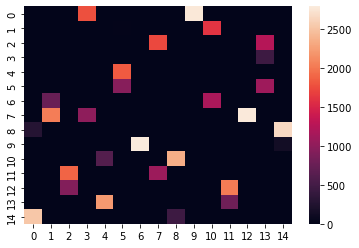

In [75]:
sns.heatmap(confusion_matrix(y_trans, y_pred))